In [20]:
using Random
using SSM
using Distributions
using Plots
using StatsBase

In [21]:
Threads.nthreads()

1

In [22]:
# generate data from a "switching gaussian regression"
n = 500
K = 2
R = 100
X = Array{Matrix{Float64}}(undef, R)
S = Array{Vector{Float64}}(undef, R)
Y = Array{Vector{Float64}}(undef, R);

In [30]:
# Exponential

A = [0.9 0.1; 0.05 0.95]
β₁ = exp.(LinRange(-10, 0, 50)) ./ (sum(exp.(LinRange(-10, 0, 50)) * mean(diff(LinRange(-15, 0, 50)))))
β₂ = exp.(LinRange(-4, 0, 50)) ./ (sum(exp.(LinRange(-4, 0, 50)) * mean(diff(LinRange(-4, 0, 50)))))
σ²₁, σ²₂ = 1.0, 1.0;

init_state = Vector{Int}(undef, R)

for ii = 1:R

    x = cat(zeros(50), randn(n, 1), dims=1);
    XX = permutedims(hcat([x[i:i+50-1] for i in 1:n]...), (2,1))

    YY = zeros(n)
    SS = zeros(Int, n)
    
    for i in 1:n
        
        if i == 1
            SS[i] = StatsBase.sample(1:K, Weights([0.5, 0.5]))
            init_state[ii] = SS[i]
        else
            SS[i] = StatsBase.sample(1:K, Weights(A[SS[i-1], :]))
        end

        if SS[i] == 1
            YY[i] = XX[i, :]'*β₁ + rand(Normal(0, sqrt(σ²₁)))
        elseif SS[i] == 2
            YY[i] = XX[i, :]'*β₂ + rand(Normal(0, sqrt(σ²₂)))
        end
    end

    X[ii] = XX;
    Y[ii] = YY;
    S[ii] = SS;
end



In [7]:
println(size(X[1]))

(500, 50)


In [13]:
using Random, StatsBase, Distributions

# Parameters
n = 100  # number of observations per trial
K = 2  # number of states
p = 2  # number of features (x1 and x2)

A = [0.9 0.1; 0.05 0.95]  # Transition matrix
β₁ = [-10.0, 5.0]  # Coefficients for state 1
β₂ = [4.0, -2.0]  # Coefficients for state 2
σ²₁, σ²₂ = 1.0, 1.0  # Variances for state 1 and state 2

R = 2  # number of trials

# Initialize containers for generated data
X = Array{Matrix{Float64}}(undef, R)
S = Array{Vector{Int}}(undef, R)
Y = Array{Vector{Float64}}(undef, R)
init_state = Vector{Int}(undef, R)

# Generate data
for ii in 1:R
    # Generate random features for each trial
    x1 = randn(n)
    x2 = randn(n)
    XX = hcat(x1, x2)  # Combine features into a matrix

    YY = zeros(n)  # Response variable
    SS = zeros(Int, n)  # State sequence

    for i in 1:n
        if i == 1
            SS[i] = StatsBase.sample(1:K, Weights([0.5, 0.5]))  # Initial state
            init_state[ii] = SS[i]
        else
            SS[i] = StatsBase.sample(1:K, Weights(A[SS[i-1], :]))  # State transition
        end

        if SS[i] == 1
            YY[i] = StatsBase.dot(XX[i, :], β₁) + rand(Normal(0, sqrt(σ²₁)))  # State 1
        elseif SS[i] == 2
            YY[i] = StatsBase.dot(XX[i, :], β₂) + rand(Normal(0, sqrt(σ²₂)))  # State 2
        end
    end

    X[ii] = XX
    Y[ii] = YY
    S[ii] = SS
end

# Print the first few generated sequences for verification
println("First few generated sequences:")
println("X[1]: ", X[1])
println("Y[1]: ", Y[1])
println("S[1]: ", S[1])


First few generated sequences:
X[1]: [1.3390133608205121 -0.8993508155057073; -0.3605442089032862 -0.3990593681373994; -1.2154200495364795 -1.2746499169508412; 1.3586882646596645 0.25671738549053835; -0.7574896148214305 -0.515240863041563; -0.6289110195518656 0.24710674160566662; -0.7310913684323269 0.17638195511377613; -0.39547486112327634 -0.48888719889978277; 0.40443563689365747 0.6183266163391106; 0.8008570200954734 1.2949923009244177; 2.443443596831704 0.6652608287238344; 0.06790411498183815 1.4547976071776623; 0.08721115518921617 0.6980030586256701; 0.5262823966119328 -1.0832839386993023; -0.6422878791759286 -0.04135876548059332; -0.33632236421107325 -0.39473017265966837; -0.8669026097115647 0.31361433847653314; 0.06347572085020568 -0.41455508584745226; 1.9079853432955265 -0.10785191987891282; -1.2475963665599812 1.3277973710843345; -0.213956415731716 -0.8540521461619365; -0.036563733337292355 -0.2141501756256077; 0.4718566919124103 1.0780597197419841; 0.5174809683374907 -0.05848

In [7]:
print(length(X[2]))

25000

In [5]:
function calculate_initial_state_probabilities(init_state::Vector{Int}, num_states::Int)
    state_counts = zeros(Int, num_states)
    total_trials = length(init_state)
    
    for state in init_state
        state_counts[state] += 1
    end
    
    initial_state_probabilities = state_counts / total_trials
    return initial_state_probabilities
end

# Example usage
num_states = 2  # Assuming there are 2 states
init_state_probabilities = calculate_initial_state_probabilities(init_state, num_states)
println("Initial state probabilities: ", init_state_probabilities)


Initial state probabilities: [0.53, 0.47]


In [6]:
mean(map(S-> S[1], S))

1.5

In [31]:
model = SwitchingGaussianRegression(;K=2, λ=1e-12)
ll, A_stor, π_stor, β1_stor, β2_stor, σ1_stor, σ2_stor = SSM.fit!(model, X, Y, 75, 1e-6, true);


Log-Lieklihood at iter 1: -583140.9313348467
Log-Lieklihood at iter 2: -85627.9558978676
Log-Lieklihood at iter 3: -83039.30780869887
Log-Lieklihood at iter 4: -80325.39897052727
Log-Lieklihood at iter 5: -77620.25522790781
Log-Lieklihood at iter 6: -76491.04850782333
Log-Lieklihood at iter 7: -76213.28110812746
Log-Lieklihood at iter 8: -76151.92033653516
Log-Lieklihood at iter 9: -76138.28761212471
Log-Lieklihood at iter 10: -76135.36553294635
Log-Lieklihood at iter 11: -76134.81882718593
Log-Lieklihood at iter 12: -76134.75129459075
Log-Lieklihood at iter 13: -76134.7502958293
Log-Lieklihood at iter 14: -76134.73965229854
Log-Lieklihood at iter 15: -76134.71358535264
Log-Lieklihood at iter 16: -76134.67739143426
Log-Lieklihood at iter 17: -76134.63584801537
Log-Lieklihood at iter 18: -76134.59192594152
Log-Lieklihood at iter 19: -76134.54728906623
Log-Lieklihood at iter 20: -76134.5028378766
Log-Lieklihood at iter 21: -76134.45905787745
Log-Lieklihood at iter 22: -76134.41621433602


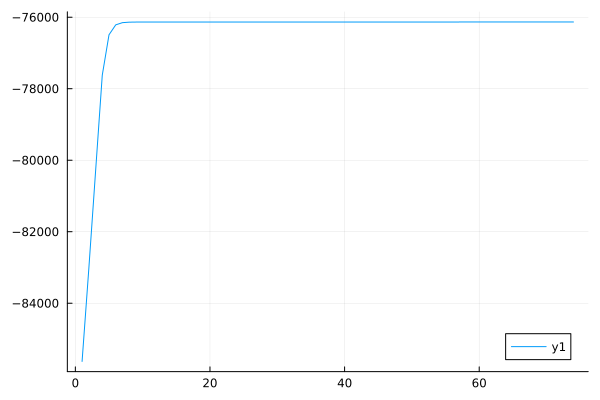

In [32]:
plot(ll[3:end])

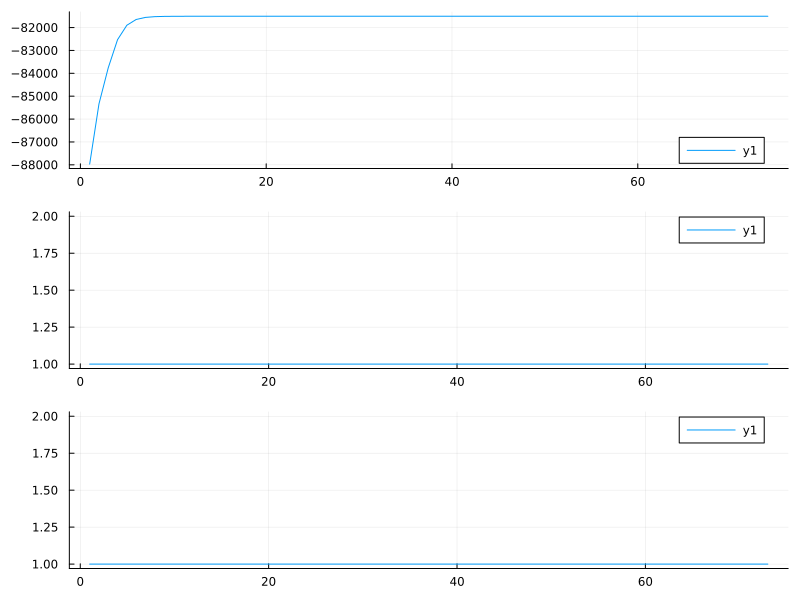

In [8]:
function z_score(x::Vector{})
    return (x.-minimum(x)) ./ (maximum(x).-minimum(x))
end

plot1 = plot(ll[3:end])
plot2 = plot(σ1_stor[3:end])
plot3 = plot(σ2_stor[3:end])
plot_grid = plot(plot1, plot2, plot3,size=(800, 600),layout=(3,1))
display(plot_grid)

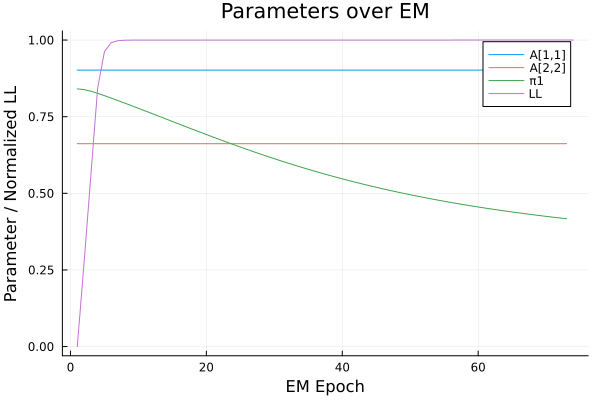

In [33]:
A11 = [A[1,1] for A in A_stor];
A22 = [A[2,2] for A in A_stor];
π1 = [π[1] for π in π_stor];


# Plot the parameters
fig3 = plot(A11[3:end], label="A[1,1]")
plot!(A22[3:end], label="A[2,2]")
plot!(π1[3:end], label="π1")
plot!(z_score(ll[3:end]), label="LL")
title!("Parameters over EM")
xlabel!("EM Epoch")
ylabel!("Parameter / Normalized LL")
plot!(legend=:topright)

In [12]:
output = SSM.E_step.(Ref(model), X, Y)
γ = map(x-> x[1], output);

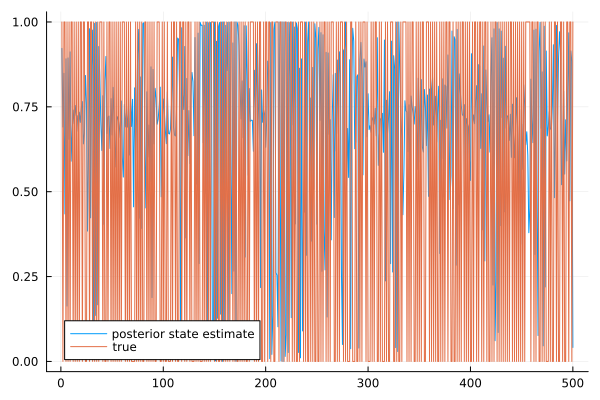

In [13]:
plot(exp.(γ[1])[:,1], label="posterior state estimate")
plot!(S[1] .- 1, label="true")

In [17]:
plot(exp.(γ[5])[:,1], label="posterior state estimate")
plot!(S[5] .- 1, label="true")

UndefVarError: UndefVarError: `γ` not defined

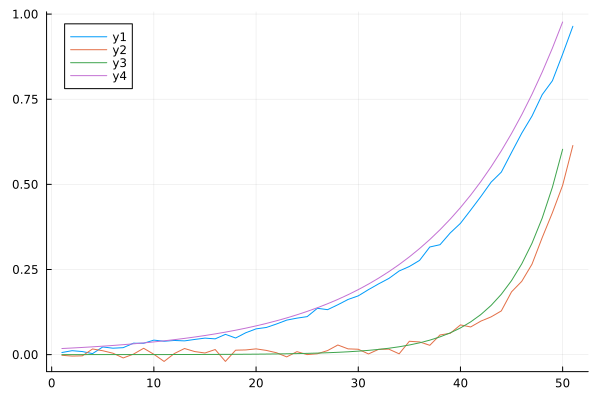

In [34]:
plot(model.B[1].regression.β)
plot!(model.B[2].regression.β)
plot!(β₁)
plot!(β₂)

In [35]:
model.A

2×2 Matrix{Float64}:
 0.901908  0.0980918
 0.338035  0.661965

In [36]:
model.πₖ

2-element Vector{Float64}:
 0.41718777325043477
 0.5828122267495651